In [1]:
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, DateFormatter


In [2]:
# This function helps to plot images that are exactly the size of what 
# you spcify in inches

def find_dpi(w, h, d):
    """
    find
    w : width in pixels
    h : height in pixels
    d : diagonal in inches
    """
    w_inches = (d ** 2 / (1 + h ** 2 / w ** 2)) ** 0.5
    return round(w / w_inches)

# macbook: 1920, 1372, 16
# screen @ home: 2560, 1440, 27
# screen @ office: 2560, 1440, 27

dpi = find_dpi(2560, 1440, 27)
print('dpi is', dpi)

dpi is 109


In [3]:
plt.rcParams['axes.labelsize']    = 10
plt.rcParams['axes.titlesize']    = 10
plt.rcParams['font.size']         = 10
plt.rcParams['xtick.labelsize']   = 10
plt.rcParams['ytick.labelsize']   = 10
plt.rcParams['legend.fontsize']   = 10
plt.rcParams['font.family']       = 'DejaVu Sans'
# plt.rcParams['xtick.major.size'] = 20
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.major.size']  = 4
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['ytick.major.size']  = 4
plt.rcParams['axes.linewidth']    = 0.5
#rcParams['xtick.minor.size'] = 10
#rcParams['xtick.minor.width'] = 2
plt.rcParams['figure.dpi'] = dpi

In [4]:
# dict that has the thresholds (in m/s) of the saffir-simpson categories
category_dict = {"TD" : 0,
                 "TS" : 17,
                 "CAT1": 33,
                 "CAT2": 43,
                 "CAT3": 50,
                 "CAT4": 58,
                 "CAT5": 70,
                }
category_dict["CAT4"]

58

In [5]:
experiment = "dyamond_3"
dx = "3.75km"

period = { "dyamond_1" : ('2016-08-01','2016-09-10'),
           "dyamond_2" : ('2020-01-20','2020-03-01'),
           "dyamond_3" : ('2020-01-20','2020-03-13'),
         }


In [6]:
tc_file  = f"/glade/campaign/mmm/wmr/fjudt/projects/{experiment}/{dx}/te/tc_tracks_6h.txt"
# tc_file = "/glade/derecho/scratch/fjudt/te/tc_tracks.txt"
df = pd.read_csv(tc_file, header=1, names=['track_id', 'year', 'month', 'day', 'hour', 'i', 'lon', 'lat', 'slp', 'wind', 'ter'])

# Create datetime column
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Print the updated dataframe
# print(df)

In [7]:
# Group the data by track_id
grouped = df.groupby('track_id')
print(f"There are {len(grouped['track_id'].unique())} unique track IDs")

# Filtering groups based on max wind speed
thresh = "CAT1"
grouped = grouped.filter(lambda x: x['wind'].max() >= category_dict[thresh]).groupby('track_id')
print(f"There are {len(grouped['track_id'].unique())} unique track IDs reaching at least {thresh} intensity")


There are 31 unique track IDs
There are 19 unique track IDs reaching at least CAT1 intensity


## Plot a map with the TC tracks

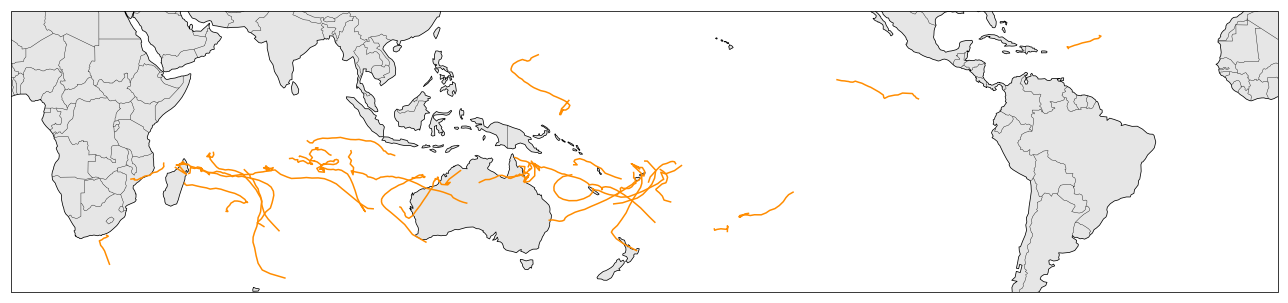

In [11]:

# Create a figure and axis using the Plate Carree projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, figsize=[15,10])

# Add coastlines and country borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.25)
ax.add_feature(cfeature.LAND, facecolor='0.90')

# Loop over the groups and plot each group on the same axis
for name, group in grouped:
    ax.plot(group['lon'], 
            group['lat'], 
            color='darkorange', 
            label=f'Track ID: {name}', 
            transform=ccrs.PlateCarree(),
            lw=1)

# Set the x and y axis limits
ax.set_xlim(-180, 180)
ax.set_ylim(-50, 30)

# Add a legend
# ax.legend()

# Show the plot
plt.show()

## Plot timeseries of TC intensities (single plot)

[Text(1, 17, 'TD'),
 Text(1, 49, 'TS'),
 Text(1, 75, 'Cat 1'),
 Text(1, 89, 'Cat 2'),
 Text(1, 104, 'Cat 3'),
 Text(1, 125, 'Cat 4'),
 Text(1, 148, 'Cat 5')]

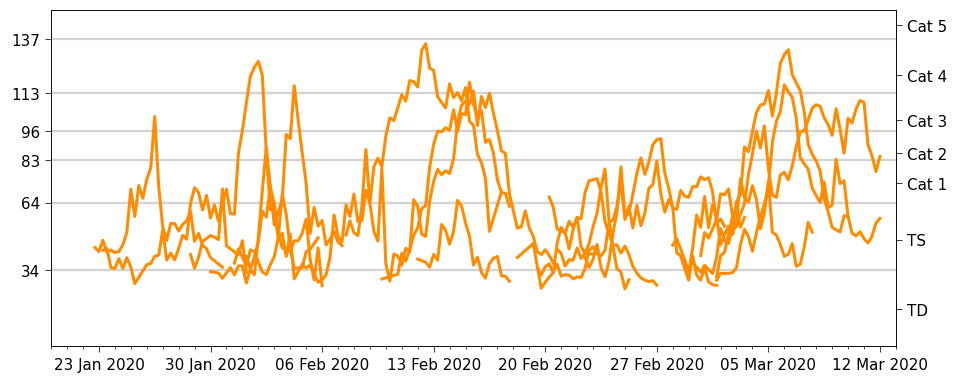

In [9]:
plt.rcParams['figure.figsize'] = [10,4]

period = period[experiment]

fig, (ax) = plt.subplots()

#ax.gridlines()

ax.axhline(y=34, color='lightgrey')
ax.axhline(y=64, color='lightgrey')
ax.axhline(y=83, color='lightgrey')
ax.axhline(y=96, color='lightgrey')
ax.axhline(y=113, color='lightgrey')
ax.axhline(y=137, color='lightgrey')

for name, group in grouped:
    # ax.plot(group['lon'], group['lat'], color='darkorange', label=f'Track ID: {name}', transform=ccrs.PlateCarree())
    # print(group)
    vmax = group['wind']
    date = group['datetime']
    ax.plot(date, vmax*1.95, color='darkorange', lw=2)
    
    ax.set_xlim(datetime.strptime(period[0],'%Y-%m-%d'),\
                datetime.strptime(period[1],'%Y-%m-%d'))
    ax.set_ylim([0, 150])


ax.get_xaxis().set_major_locator(DayLocator(interval=7))
ax.get_xaxis().set_major_formatter(DateFormatter("%d %b %Y"))
ax.get_xaxis().set_minor_locator(DayLocator(interval=1))
#fig.autofmt_xdate()

ax.set_yticks([34,64,83,96,113,137])

# Right y-axis with SS categories
ax2 = ax.twinx()
ax2.set_ylim([0, 155])
#ax2.set_yticks([34,64,83,96,113,137])
ax2.set_yticks([17,49,75,89,104,125,148])
ax2.set_yticklabels(['TD','TS','Cat 1','Cat 2','Cat 3','Cat 4','Cat 5'])



## Plot a map with TC tracks color-coded by intensity (borrowed from D. Ahijevych)

Number of TCs 31 
    Number of TD: 0
    Number of TS: 12
    Number of CAT1: 9
    Number of CAT2: 1
    Number of CAT3: 2
    Number of CAT4: 7
    Number of CAT5: 0


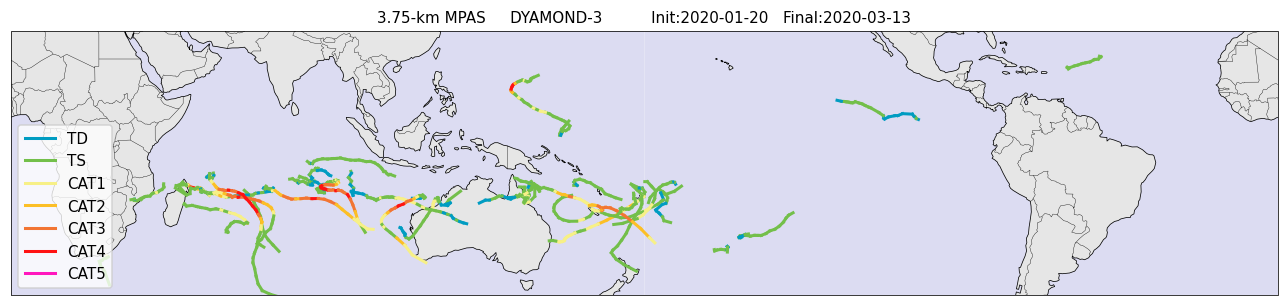

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# # Specify the path to the tropical cyclone tracks file
# tc_file = f"/glade/campaign/mmm/wmr/fjudt/projects/{experiment}/{dx}/te/tc_tracks.txt"

# # Read the data into a DataFrame
# df = pd.read_csv(tc_file, header=1, names=['track_id', 'year', 'month', 'day', 'hour', 'i', 'lon', 'lat', 'slp', 'wind', 'zgrid'])

# # Create datetime column
# df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Define the wind speed categories and their corresponding colors
categories = {
    # "NONTD": "white",
    "TD": (.00, .61, .76),
    "TS": (.45, .75, .29),
    "CAT1": (.97, .94, .53),
    "CAT2": (.99, .75, .15),
    "CAT3": (.95, .46, .20),
    "CAT4": (1, .07, .07),
    "CAT5": (1.0, .09, .74)
}

# Convert wind speeds to categories
def vmax2category(vmax):
    kt = 0.514444  # Convert from knots to meters per second
    if vmax > 137 * kt:
        category = "CAT5"
    elif vmax > 113 * kt:
        category = "CAT4"
    elif vmax > 96 * kt:
        category = "CAT3"
    elif vmax > 83 * kt:
        category = "CAT2"
    elif vmax > 64 * kt:
        category = "CAT1"
    elif vmax > 34 * kt:
        category = "TS"
    else:
        category = "TD"
    return category

# Group the data by track_id
grouped = df.groupby('track_id')

# Get the unique track IDs
unique_track_ids = pd.unique(df['track_id'])
num_track_ids = len(unique_track_ids)
print(f"Number of TCs {num_track_ids} ")

# Filter tracks that do not have any instances of category "TS"
# filtered_track_ids = []
# for name, group in grouped:
#     if any(category in ['TD', 'TS', 'CAT1', 'CAT2', 'CAT3', 'CAT4', 'CAT5'] for category in group['wind'].apply(vmax2category).values):
#         filtered_track_ids.append(name)
# print(f"Number of filtered track IDs: {len(filtered_track_ids)}")
# filtered_track_ids = []

# Count the number of track IDs that reach each wind category
category_counts = {
    'TD': 0,
    'TS': 0,
    'CAT1': 0,
    'CAT2': 0,
    'CAT3': 0,
    'CAT4': 0,
    'CAT5': 0
}

filtered_track_ids = set()

for name, group in grouped:
    max_wind = group['wind'].max()
    max_category = vmax2category(max_wind)
    category_counts[max_category] += 1
    filtered_track_ids.add(name)
num_track_ids = len(filtered_track_ids)

# print(f"Number of filtered track IDs: {num_track_ids}")
for category, count in category_counts.items():
    print(f"    Number of {category}: {count}")
    
# Create a figure and axis using the Plate Carree projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, 
                       figsize=(15, 15))

# Add coastlines and country borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.25)
ax.add_feature(cfeature.LAND, facecolor='0.90')
ax.add_feature(cfeature.OCEAN, facecolor=np.array([220., 220., 242.]) / 255.)

# Loop over the filtered track IDs and plot each track on the same axis
for track_id in filtered_track_ids:
    track_data = grouped.get_group(track_id)
    category_values = track_data['wind'].apply(vmax2category)  # Wind categories for the current track

    # Plot individual line segments with different colors for each point along the track
    for i in range(len(track_data) - 1):
        lon1, lat1 = track_data.iloc[i]['lon'], track_data.iloc[i]['lat']
        lon2, lat2 = track_data.iloc[i + 1]['lon'], track_data.iloc[i + 1]['lat']
        category = category_values.iloc[i]
        color = categories[category]
        ax.plot([lon1, lon2], [lat1, lat2], color=color, linewidth=2, transform=ccrs.PlateCarree())

# Set the lat and lon axis limits
ax.set_xlim(-180, 180)
ax.set_ylim(-45, 30)
ax.set_title(f"3.75-km MPAS     DYAMOND-3          Init:{period[0]}   Final:{period[1]}")

# Add a legend
handles = [plt.Line2D([], [], color=categories[category], linewidth=2) for category in categories]
labels = list(categories.keys())
ax.legend(handles, labels, loc='lower left')

# Show the plot
plt.show()